# [房价预测 Kernel][link]

[link]:https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
def ignore_warn(*args, **kwargs): pass
from scipy import stats
from scipy.stats import norm, skew #for some statistics
%matplotlib inline
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
color = sns.color_palette()
sns.set_style('darkgrid')
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train_ID = train['Id']
test_ID = test['Id']

In [4]:
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

# Data Processing

## OutLiers

In [5]:
def y_x_scatter(df, y, x, lim=800000):
    tmp = pd.concat([df[y], df[x]], axis=1)
    tmp.plot.scatter(x=x, y=y, ylim=(0, lim))

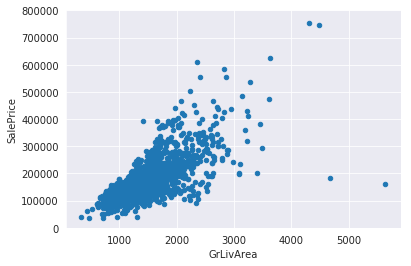

In [6]:
# 有两个异常点
y_x_scatter(train, 'SalePrice', 'GrLivArea')

In [7]:
train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index, inplace=True)

# 目标值分析  SalePrice

Text(0.5,1,'SalePrice distribution')

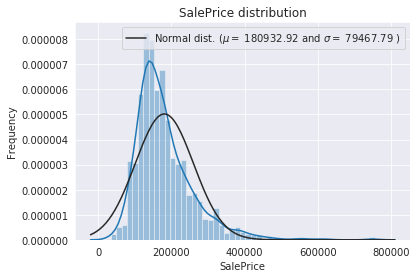

In [8]:
sns.distplot(train['SalePrice'] , fit=norm)
#Now plot the distribution
(mu, sigma) = norm.fit(train['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

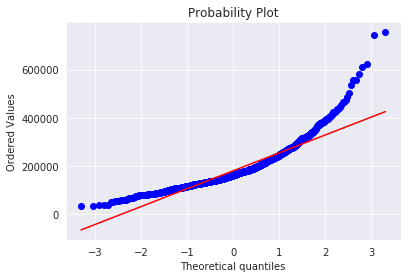

In [9]:
# 为什么要做正态性检验
# 参考：https://blog.csdn.net/cyan_soul/article/details/81236124
# 分位数，参考：https://baike.baidu.com/item/%E5%88%86%E4%BD%8D%E6%95%B0/10064158
# 越靠近y=x，越符合正太分布
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

## 由于上面数据有点重心往左偏，需要取log使其服从正态分布

为什么取对数就服从正态分布了，我还是不太懂。参考链接如下：

- [在统计学中为什么要对变量取对数？][1]
- [为什么数据要取对数][2]

[1]: https://www.zhihu.com/question/22012482
[2]: https://blog.csdn.net/xiezhen_zheng/article/details/81103134

In [10]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

Text(0.5,1,'SalePrice distribution')

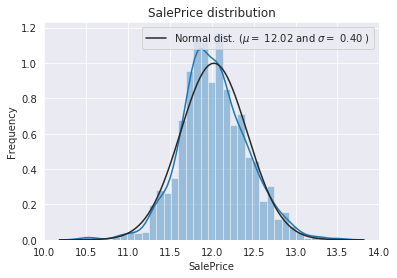

In [11]:
#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm)
(mu, sigma) = norm.fit(train['SalePrice'])

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

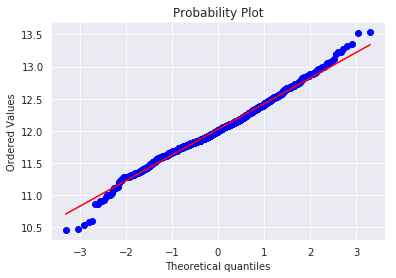

In [12]:
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

# 特征工程

In [13]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print('all_data shape is : {}'.format(all_data.shape))

all_data shape is : (2917, 79)


## 缺失数据

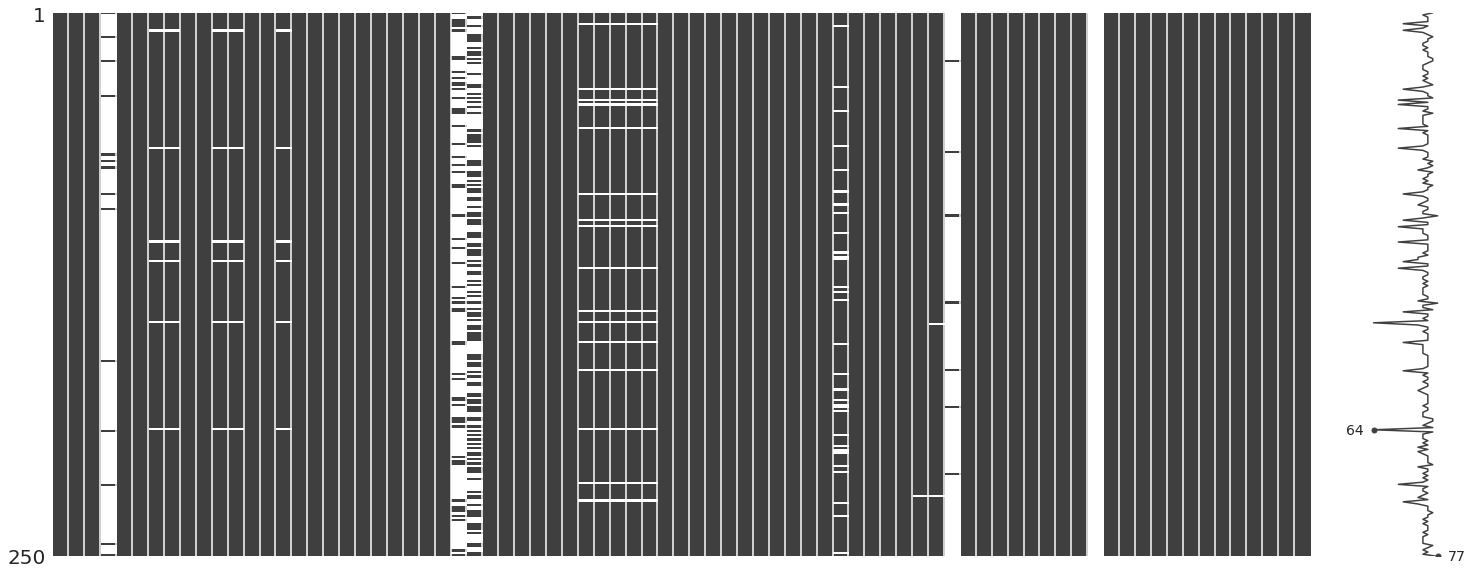

In [14]:
msno.matrix(all_data.sample(250))

In [15]:
def missing_rate(df):
    all_data_na = (df.isnull().sum() / len(df)) * 100
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
    missing = pd.DataFrame({'Missing Ratio': all_data_na})
    return missing.head(30)

In [16]:
missing_rate(all_data)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


In [17]:
# 没用的列直接丢弃
all_data.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], inplace=True)

查看有多少是枚举类型的

In [18]:
def get_categorical_kinds(df):
    categs = []
    for column_name in df.columns:
        if df[column_name].dtypes == 'object':
            seris = df[column_name].fillna(df[column_name].mode().iloc[0])
            unique_category = len(seris.unique())
            categs.append([column_name, unique_category])
    categs_df = pd.DataFrame(categs, columns=['name', 'kinds'])
    return categs_df.sort_values(by=['kinds'], ascending=False)

In [19]:
# get_categorical_kinds(all_data)

In [20]:
missing_rate(all_data)

,Missing Ratio
LotFrontage,16.661
GarageYrBlt,5.451
GarageQual,5.451
GarageFinish,5.451
GarageCond,5.451
GarageType,5.382
BsmtCond,2.811
BsmtExposure,2.811
BsmtQual,2.777
BsmtFinType2,2.743


In [21]:
numeric_features = all_data.select_dtypes(include=[np.number])
numeric_features.columns

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal',
       'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea',
       'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd', 'YrSold'],
      dtype='object')

In [22]:
categorical_features = all_data.select_dtypes(include=[np.object])
categorical_features.columns

Index(['BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical',
       'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Foundation',
       'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType',
       'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour',
       'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType',
       'Neighborhood', 'PavedDrive', 'RoofMatl', 'RoofStyle', 'SaleCondition',
       'SaleType', 'Street', 'Utilities'],
      dtype='object')

In [23]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [24]:
# 对于下面四个garage相关的categorical feature，空值填 'None'
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col].fillna('None', inplace=True)

In [25]:
# 对于下面四个garage相关的numerical feature，空值填 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col].fillna(0, inplace=True)

In [26]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col].fillna(0, inplace=True)

In [27]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col].fillna('None', inplace=True)

In [28]:
all_data["MasVnrType"].fillna('None', inplace=True)
all_data["MasVnrArea"].fillna(0, inplace=True)

In [29]:
# 关于mode众数参考：https://www.cnblogs.com/tsingke/p/4774238.html
# 用众数填充空值
all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0], inplace=True)

In [30]:
# Utilities 全是几乎同一类，没有价值，删除
all_data.drop(['Utilities'], axis=1, inplace=True)

In [31]:
# 也用众数填充
all_data['Functional'].fillna(all_data['Functional'].mode()[0], inplace=True)
all_data['Electrical'].fillna(all_data['Electrical'].mode()[0], inplace=True)
all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0], inplace=True)
all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0], inplace=True)
all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0], inplace=True)
all_data['SaleType'].fillna(all_data['SaleType'].mode()[0], inplace=True)

In [32]:
# 看看还有没有missing value，没有啦
missing_rate(all_data)

,Missing Ratio


## 更多特征工程细节

In [33]:
# 下面这几个虽然是numberical，但实际上是categorical，需要转成str
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].apply(str)
all_data['YrSold'] = all_data['YrSold'].apply(str)
all_data['MoSold'] = all_data['MoSold'].apply(str)

In [34]:
from sklearn.preprocessing import LabelEncoder

In [35]:
# 下面的所有categorical变量需要转成0-len-1数字，因为他们可能包含了某种
cols = {'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold'}

In [36]:
# 转成连续的整数，比起one-hot encoding要好，不会那么稀疏了
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [37]:
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 73)


## 再加一个特征

In [38]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

## Skewed features 偏斜特征 ？？？？

In [39]:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

In [40]:
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

In [41]:
# 关于偏度skewness、峰度Kurtosis 参考：https://blog.csdn.net/xbmatrix/article/details/69360167
skewness = pd.DataFrame({'Skew': skewed_feats})
skewness.head(10)

,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


## 使用Box Cox 对偏度数据进行校正

[北交课件：Box-Cox变换][1]

[1]:https://wenku.baidu.com/view/96140c8376a20029bd642de3.html

In [42]:
skewness = skewness[abs(skewness.Skew) > 0.75]

In [43]:
skewness.shape

(34, 1)

In [44]:
from scipy.special import boxcox1p

In [45]:
skewed_features = skewness.index

In [46]:
lam = 0.15

In [47]:
for f in skewed_features:
    all_data[f] = boxcox1p(all_data[f], lam)

# 剩下的全部转换成one-hot dummies

In [48]:
all_data = pd.get_dummies(all_data)

In [49]:
all_data.shape

(2917, 211)

# 重新创建train和test

In [50]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# -----------------------------分界线-----------------------------

开始建模了

In [51]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

## 使用交叉验证 Cross Validation

In [52]:
def time_cost(start, end):
    secs = int(end - start)
    h = secs // 3600
    m = (secs - h * 3600) // 60
    print('\ntime cost %shour %sminute\n\n' % (h, m))

In [53]:
n_folds = 5

In [54]:
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring='neg_mean_squared_error', cv=kf))
    return rmse

In [55]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

## Base models

In [56]:
# LASSO Regression
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

In [57]:
# Elastic Net Regression
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [58]:
# Kernel Ridge Regression
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [59]:
# Gradient Boosting Regression
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                  max_depth=4, max_features='sqrt',
                                  min_samples_leaf=15, min_samples_split=10,
                                  loss='huber', random_state=5)

In [60]:
# XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [61]:
# LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

## 预测并保存csv

In [62]:
def save_predict(pred, model_name, score):
    csv = './predict/%s_%.5f.csv' % (model_name, score)
    sub = pd.DataFrame()
    sub['ID'] = test_ID
    sub['SalePrice'] = pred
    sub.to_csv(csv, index=False)
    print('Save %s predict finish!' % model_name)

In [63]:
def model_predict_save_csv(model, model_name):
    t0 = time()
    score = rmsle_cv(model).mean()
    print('%s score: %.5f' % (model_name, score))
    model.fit(train.values, y_train)
    pred = model.predict(test.values)
    pred = np.expm1(pred)
    save_predict(pred, model_name, score)
    time_cost(t0, time())

In [64]:
# model_predict_save_csv(lasso, 'lasso')

In [65]:
# model_predict_save_csv(ENet, 'ENet')

In [66]:
# model_predict_save_csv(KRR, 'KRR')

In [67]:
# model_predict_save_csv(GBoost, 'GBoost')

In [68]:
# model_predict_save_csv(model_xgb, 'model_xgb')

In [69]:
# model_predict_save_csv(model_lgb, 'model_lgb')

## 模型集成：Stacking

### 最简单的 Averaging base models 取平均值

In [70]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, models):
        self.models = models
    
    
    def fit(self, x, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(x, y)
        
        return self
    
    
    def predict(self, x):
        predictions = np.column_stack([model.predict(x) for model in self.models_])
        return np.mean(predictions, axis=1)

In [71]:
averaged_models = AveragingModels(models=(lasso, ENet, KRR, GBoost))

In [72]:
# model_predict_save_csv(averaged_models, 'averaged_models')

## 另一种更复杂的集成方式


![如图所示](http://i.imgur.com/QBuDOjs.jpg)

In [73]:
class StackingAverageModels(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
    
    def fit(self, x, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(self.n_folds, shuffle=True, random_state=156)
        
        out_of_fold_predictions = np.zeros((x.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(x, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(x[train_index], y[train_index])
                y_pred = instance.predict(x[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
        
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    
    def predict(self, x):
        meta_features = np.column_stack([np.column_stack([model.predict(x) for model in base_models]).mean(axis=1) 
                                         for base_models in self.base_models_])
        return self.meta_model_.predict(meta_features)

In [74]:
stacked_averaged_models = StackingAverageModels(base_models=(ENet, GBoost, KRR), meta_model=lasso)

In [75]:
# model_predict_save_csv(stacked_averaged_models, 'stacked_averaged_models')

In [76]:
# stacked_models_b = StackingAverageModels(base_models=(lasso, ENet, GBoost, KRR), meta_model=lasso)

In [77]:
# model_predict_save_csv(stacked_models_b, 'stacked_models_b')

In [78]:
# stacked_models_c = StackingAverageModels(base_models=(lasso, ENet, KRR), meta_model=lasso)

In [79]:
# model_predict_save_csv(stacked_models_c, 'stacked_models_c')

In [80]:
# 这是我想的Stack方式，没有用K-fold Cross Validation，并不是很好
class SimpleStackingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, base_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model
    
    def fit(self, x, y):
        self.base_models_ = [clone(x) for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        
        
        out_of_fold_predictions = np.zeros((x.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models_):
            model.fit(x, y)
            y_pred = model.predict(x)
            out_of_fold_predictions[:, i] = y_pred
        
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    
    def predict(self, x):
        meta_features = np.column_stack([model.predict(x) for model in self.base_models_])
        return self.meta_model_.predict(meta_features)

In [81]:
# stacked_models_d = SimpleStackingModels(base_models=(stacked_averaged_models, model_lgb, model_xgb), meta_model=lasso)

In [82]:
# model_predict_save_csv(stacked_models_d, 'stacked_models_d')

## 最终模型集成：线性组合模型

## StackedRegressor

In [83]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
print(rmsle(y_train, stacked_train_pred))
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))

0.08082620068044881


In [84]:
model_xgb.fit(train.values, y_train)
xgb_train_pred = model_xgb.predict(train.values)
print(rmsle(y_train, xgb_train_pred))
xgb_pred = np.expm1(model_xgb.predict(test.values))

0.08161750551244872


In [85]:
model_lgb.fit(train.values, y_train)
lgb_train_pred = model_lgb.predict(train.values)
print(rmsle(y_train, lgb_train_pred))
lgb_pred = np.expm1(model_lgb.predict(test.values))

0.07261184391615426


In [86]:
print('RMSLE score on train data:')
print(rmsle(y_train, stacked_train_pred*0.70 + xgb_train_pred*0.15 + lgb_train_pred*0.15))

RMSLE score on train data:
0.07772472169226413


# 集成预测

In [87]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [88]:
# save_predict(ensemble, 'stackedRegressor+XGBoost+LightGBM', 0.07772)

# -----------------------------分界线-----------------------------

- 结论1：集成的模型性能始终比单个模型好
- 结论2：在集成的模型中 stackb:  stack(Enet+lasso+KRR+Gboost)+lasso 性能最优，取得了最佳得分；stacka:  stack(Enet+Gboost+KRR)+lasso 分数与之很接近